In [1]:
import nltk
nltk.download('vader_lexicon')   # needed for VADER
nltk.download('punkt')           # for TextBlob tokenization if used

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tselot88/nltk_data...
[nltk_data] Downloading package punkt to /home/tselot88/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
# Cell A
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time
from dateutil import tz
from pandas.tseries.offsets import BDay
import statsmodels.api as sm

# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sns.set_style("whitegrid")

# Paths
DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"

# Correct processed files
NEWS_PATH = PROCESSED_DIR / "news_enriched.parquet"
STOCKS_PATH = PROCESSED_DIR / "all_stocks_enriched.parquet"


In [8]:
# Cell B: Load news
news = pd.read_parquet(NEWS_PATH)

# ensure date parse
news['date'] = pd.to_datetime(news['date'], utc=True, errors='coerce')
news = news.dropna(subset=['date']).reset_index(drop=True)

# Convert news timestamps to Eastern Time (market timezone)
news['date_et'] = news['date'].dt.tz_convert('America/New_York')

# Helper: compute trading_date
market_close = time(16, 0)  # 16:00 = 4:00 PM ET

def assign_trading_date(row):
    dt = row['date_et']
    # weekend → next business day
    if dt.weekday() >= 5:
        next_bd = (dt + BDay(1)).normalize().tz_localize(None).date()
        return next_bd
    # before market close → same day
    if dt.time() < market_close:
        return dt.date()
    # after close → next business day
    next_bd = (dt + BDay(1)).normalize().tz_localize(None).date()
    return next_bd

news['trading_date'] = news.apply(assign_trading_date, axis=1)

# Normalize stock tickers
news['stock'] = news['stock'].astype(str).str.upper().str.strip()

news.head()


,Unnamed: 0,headline,url,publisher,date,stock,headline_len,date_only,hour,date_et,trading_date
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,39,2020-06-05,10.0,2020-06-05 10:30:54-04:00,2020-06-05
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,42,2020-06-03,10.0,2020-06-03 10:45:20-04:00,2020-06-03
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,29,2020-05-26,4.0,2020-05-26 04:30:07-04:00,2020-05-26
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,44,2020-05-22,12.0,2020-05-22 12:45:06-04:00,2020-05-22
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,87,2020-05-22,11.0,2020-05-22 11:38:59-04:00,2020-05-22


In [9]:
# Cell C: compute sentiment
def vader_score(text):
    if pd.isna(text) or str(text).strip()=="":
        return np.nan
    s = analyzer.polarity_scores(str(text))
    return s['compound']

news['vader_compound'] = news['headline'].astype(str).apply(vader_score)

# Optional: also compute TextBlob polarity (backup)
#from textblob import TextBlob
#news['tb_polarity'] = news['headline'].astype(str).apply(lambda t: TextBlob(t).sentiment.polarity)

# quick check
print("Sentiment sample:", news[['headline','vader_compound']].head(5))


Sentiment sample:                                             headline  vader_compound
0            Stocks That Hit 52-Week Highs On Friday           0.000
1         Stocks That Hit 52-Week Highs On Wednesday           0.000
2                      71 Biggest Movers From Friday           0.000
3       46 Stocks Moving In Friday's Mid-Day Session           0.000
4  B of A Securities Maintains Neutral on Agilent...           0.296


In [11]:
# Cell D: aggregate

# Identify stock tickers from processed file names
valid_stocks = [p.name.split('_')[0].upper() for p in PROCESSED_DIR.glob("*_enriched.parquet")]

# Keep only rows belonging to known stocks
news = news[news['stock'].isin(valid_stocks)].copy()

# Compute headline length
news['headline_len'] = news['headline'].astype(str).str.len()

# --- First: Standard aggregations (mean, median, count) ---
agg = news.groupby(['stock', 'trading_date']).agg(
    sentiment_mean=('vader_compound', 'mean'),
    sentiment_median=('vader_compound', 'median'),
    n_articles=('vader_compound', 'count')
).reset_index()

# --- Second: Weighted sentiment score ---
def weighted_mean(group):
    vals = group['vader_compound'].values
    weights = group['headline_len'].values
    if weights.sum() == 0:
        return np.nan
    return np.average(vals, weights=weights)

wt = (
    news.groupby(['stock', 'trading_date'])
    .apply(weighted_mean)
    .rename("sentiment_wt")
    .reset_index()
)

# Merge weighted metric with the first aggregation
agg = agg.merge(wt, on=['stock', 'trading_date'])

agg.head()


,stock,trading_date,sentiment_mean,sentiment_median,n_articles,sentiment_wt
0,AAPL,2020-06-09,0.24690,0.22020,4,0.382625
1,AAPL,2020-06-10,0.19885,0.12695,6,0.225773
2,ALL,2020-05-06,0.00000,0.00000,1,0.000000
3,ALL,2020-05-08,0.00000,0.00000,1,0.000000
4,ALL,2020-05-13,-0.64860,-0.64860,1,-0.648600


In [13]:
valid_stocks = []

for p in PROCESSED_DIR.glob("*_enriched.parquet"):
    name = p.name.split("_")[0].upper()

    # skip aggregator and news files
    if name in ["NEWS", "ALL"]:
        continue

    valid_stocks.append(name)


In [14]:
# Cell E: load enriched stock data and compute returns
def load_stock_parquet(ticker):
    path = PROCESSED_DIR / f"{ticker}_enriched.parquet"
    df = pd.read_parquet(path)
    # ensure Date index
    if isinstance(df.index, pd.RangeIndex):
        # maybe Date became a column
        if 'Date' in df.columns:
            df = df.set_index('Date')
    df.index = pd.to_datetime(df.index).date if not hasattr(df.index, 'tz') else pd.to_datetime(df.index).tz_localize(None).date
    df = df.sort_index()
    return df

# Build returns dataframe per ticker
returns_list = []
for ticker in valid_stocks:
    df = pd.read_parquet(PROCESSED_DIR / f"{ticker}_enriched.parquet")
    df.index = pd.to_datetime(df.index).date
    df = df.sort_index()
    df = df[['Close']].copy()
    df['daily_return'] = df['Close'].pct_change()
    df['Stock'] = ticker
    df = df.reset_index().rename(columns={'index':'trading_date'})
    returns_list.append(df[['Stock','trading_date','daily_return','Close']])

returns_df = pd.concat(returns_list, ignore_index=True)
returns_df['trading_date'] = pd.to_datetime(returns_df['trading_date']).dt.date
returns_df.head()


,Stock,trading_date,daily_return,Close
0,GOOG,2009-01-02,NaN,7.948608
1,GOOG,2009-01-05,0.020945,8.115089
2,GOOG,2009-01-06,0.018321,8.263762
3,GOOG,2009-01-07,-0.036071,7.965677
4,GOOG,2009-01-08,0.009875,8.044340


In [26]:
# Make sure tickers are uppercase and stripped
agg['stock'] = agg['stock'].str.upper().str.strip()
returns_df['Stock'] = returns_df['Stock'].str.upper().str.strip()

# Make sure trading_date is datetime64[ns] for both
agg['trading_date'] = pd.to_datetime(agg['trading_date'])
returns_df['trading_date'] = pd.to_datetime(returns_df['trading_date'])


In [27]:
merged = pd.merge(
    returns_df,
    agg,
    how='left',
    left_on=['Stock','trading_date'],
    right_on=['stock','trading_date']
)

# Optional: clean and rename columns
merged = merged.rename(columns={'sentiment_mean':'sentiment', 'sentiment_wt':'sentiment_wt'})

# Optional: fill missing sentiment with 0 if you want to treat no-news days as neutral
merged['sentiment'] = merged['sentiment'].fillna(0)
merged['sentiment_wt'] = merged['sentiment_wt'].fillna(0)
merged['n_articles'] = merged['n_articles'].fillna(0)

# Quick check
merged[['Stock','trading_date','daily_return','sentiment','sentiment_wt','n_articles']].head(10)


,Stock,trading_date,daily_return,sentiment,sentiment_wt,n_articles
0,GOOG,2009-01-02,NaN,0.0,0.0,0.0
1,GOOG,2009-01-05,0.020945,0.0,0.0,0.0
2,GOOG,2009-01-06,0.018321,0.0,0.0,0.0
3,GOOG,2009-01-07,-0.036071,0.0,0.0,0.0
4,GOOG,2009-01-08,0.009875,0.0,0.0,0.0
5,GOOG,2009-01-09,-0.031120,0.0,0.0,0.0
6,GOOG,2009-01-12,-0.007554,0.0,0.0,0.0
7,GOOG,2009-01-13,0.005213,0.0,0.0,0.0
8,GOOG,2009-01-14,-0.042473,0.0,0.0,0.0
9,GOOG,2009-01-15,-0.006579,0.0,0.0,0.0


In [35]:
from scipy.stats import pearsonr, spearmanr

def compute_correlations(df, min_obs=30):
    results = []
    for ticker, g in df.groupby('Stock'):
        sub = g.dropna(subset=['daily_return','sentiment'])
        if len(sub) < min_obs:
            continue
        # skip constant sentiment
        if sub['sentiment'].nunique() < 2:
            continue
        pearson_r, pearson_p = pearsonr(sub['sentiment'], sub['daily_return'])
        spearman_r, spearman_p = spearmanr(sub['sentiment'], sub['daily_return'])
        results.append({
            'Stock': ticker,
            'pearson_r': pearson_r, 'pearson_p': pearson_p,
            'spearman_r': spearman_r, 'spearman_p': spearman_p,
            'n': len(sub)
        })
    return pd.DataFrame(results)


corr_df = compute_correlations(merged)

if corr_df.empty:
    print("No valid pairs for correlation. Check if sentiment and daily_return align by date.")
else:
    # sort by strongest correlation
    corr_df = corr_df.sort_values('pearson_r', ascending=False)
    display(corr_df.head(10))


,Stock,pearson_r,pearson_p,spearman_r,spearman_p,n
0,AAPL,0.035194,0.030639,0.035501,0.029211,3773
1,AMZN,0.016391,0.314161,0.031091,0.056183,3773
3,NVDA,0.012407,0.446138,0.008971,0.581739,3773
2,GOOG,-0.003734,0.818628,-0.001827,0.910697,3773


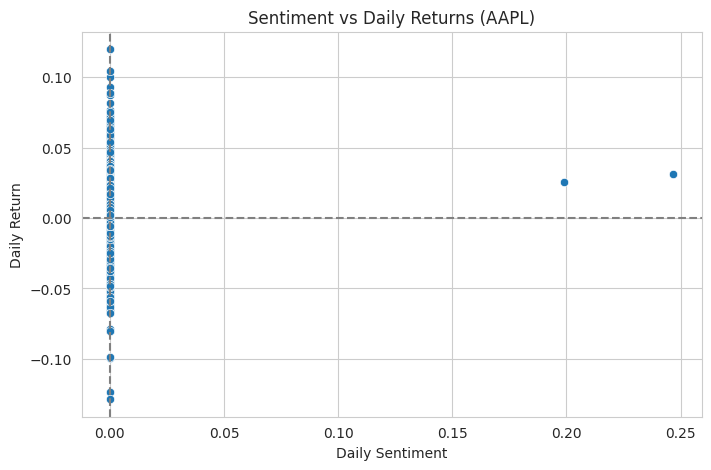

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Example: scatter for a stock
sample_stock = 'AAPL'
sample_data = merged[merged['Stock'] == sample_stock]

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=sample_data,
    x='sentiment',
    y='daily_return'
)
plt.title(f'Sentiment vs Daily Returns ({sample_stock})')
plt.xlabel('Daily Sentiment')
plt.ylabel('Daily Return')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()


In [37]:
reg_results = {}

for ticker, g in merged.groupby('Stock'):
    # drop rows without returns or sentiment
    df_reg = g.dropna(subset=['daily_return','sentiment']).copy()
    
    # skip if too few observations
    if len(df_reg) < 50:
        continue
    
    # Compute rolling 20-day volatility (annualized)
    df_reg['vol_20'] = df_reg['daily_return'].rolling(20).std() * np.sqrt(252)
    
    # Lagged return
    df_reg['lag_return'] = df_reg['daily_return'].shift(1)
    
    # Drop rows with NaN after rolling/lag
    df_reg = df_reg.dropna(subset=['vol_20','lag_return'])
    
    # Regression
    X = df_reg[['sentiment','vol_20','lag_return']]
    X = sm.add_constant(X)
    y = df_reg['daily_return']
    
    model = sm.OLS(y, X).fit()
    reg_results[ticker] = model
    
    # Print regression table
    print(f"\nTicker: {ticker}")
    print(model.summary().tables[1])


Ticker: AAPL
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.606      0.108      -0.000       0.003
sentiment      0.1254      0.056      2.220      0.027       0.015       0.236
vol_20         0.0005      0.003      0.208      0.835      -0.005       0.006
lag_return    -0.0347      0.016     -2.126      0.034      -0.067      -0.003

Ticker: AMZN
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.403      0.687      -0.002       0.001
sentiment      0.0581      0.054      1.076      0.282      -0.048       0.164
vol_20         0.0052      0.002      2.107      0.035       0.000       0.010
lag_return    -0.0128      0.016     -0.792      0.428      -0.045       0.019

Ticker: GOOG
          

In [38]:
# Cell H: save results
agg.to_parquet(DATA_DIR / 'daily_sentiment_by_stock.parquet')
merged.to_parquet(DATA_DIR / 'sentiment_returns_merged.parquet')
lag_df.to_csv(DATA_DIR / 'lagged_correlations.csv', index=False)
corr_df.to_csv(DATA_DIR / 'same_day_correlations.csv', index=False)
